In [1]:
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import pandas as pd

import re

## Features 

In [2]:
import re

indexes = []
features = []
with open('../homework2_exercise2/data/features', 'r') as f:
    for line in f.readlines():
        index, *feat = line.split(':')
        feat = ''.join(feat)
        feat = re.findall('"([^\"]*)"', feat)
        indexes.append(index)
    
        
        feat += [f.split('_')[0] for f in feat]
        feat = list(set(feat))
        
        features.append(feat)

In [3]:
one_hot = MultiLabelBinarizer()
mhe = one_hot.fit_transform(features)
df = pd.DataFrame(mhe)

In [4]:
df.rename(columns=lambda x: f'feat_{x}', inplace=True)
df = df.T.drop_duplicates().T
df = df.astype(bool)
df['theorem'] = indexes

In [5]:
del mhe
del features
del indexes

# Dataset

## Ones

In [6]:
indexes_train = []
premises = []

ones = []

with open('../homework2_exercise2/data/dependencies_train', 'r') as f:
    for line in f.readlines():
        index, *prem = line.split(':')
        prem = ''.join(prem).split()
        
        indexes_train.append(index)
        premises.append(prem)
        
        for p in prem:
            ones.append((index, p))

In [7]:
ones_df = pd.DataFrame(ones, columns=['theorem', 'premise']).drop_duplicates()

In [8]:
del ones
del premises
del indexes_train

## Zeros

In [9]:
chronology = pd.read_csv('../homework2_exercise2/data/chronology_backup', squeeze=True, names=['chronology'])
def get_available_theorems(name):
    return chronology.loc[:(chronology == name).argmax()-1]

In [10]:
used_premises = ones_df.groupby('theorem')['premise'].unique()

In [11]:
FALSE_EXAMPLES_RATIO = 3

dataset_zeros = []
for theorem, theorem_premises in ones_df.groupby('theorem')['premise']:
    available_theorems = get_available_theorems(theorem)
    zero_premises = np.setdiff1d(available_theorems, theorem_premises)
    
    zeros_chosen = zero_premises[np.random.randint(0, len(zero_premises), FALSE_EXAMPLES_RATIO * theorem_premises.shape[0])]
    dataset_zeros += list(zip(
        [theorem] * len(zeros_chosen),
        zeros_chosen
    ))

/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
zeros_df = pd.DataFrame(dataset_zeros, columns=['theorem', 'premise'])

In [13]:
del dataset_zeros
del used_premises

##  Merging

In [14]:
zeros_df['useful'] = 0
ones_df['useful'] = 1
df_train = pd.concat([zeros_df, ones_df])

In [15]:
del zeros_df
del ones_df

In [16]:
def map_features(thm_prem_pairs):
    df_values = pd.merge(
        thm_prem_pairs, df,
        left_on=['theorem'],
        right_on=['theorem']
    )
    df_values = pd.merge(
        df_values, df,
        left_on=['premise'],
        right_on=['theorem'],
        suffixes=('_prem', '_thm')
    ).drop(['theorem_thm'], axis=1).rename(columns={'theorem_prem': 'theorem'})
    return df_values

In [17]:
df_train = map_features(df_train)
df_train.head()

,theorem,premise,useful,feat_0_prem,feat_1_prem,feat_2_prem,feat_3_prem,feat_4_prem,feat_6_prem,feat_7_prem,...,feat_10348_thm,feat_10353_thm,feat_10355_thm,feat_10358_thm,feat_10361_thm,feat_10362_thm,feat_10365_thm,feat_10368_thm,feat_10373_thm,feat_10376_thm
0,t100_tmap_1,t188_relat_1,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,t157_funct_1,t188_relat_1,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,t157_funct_1,t188_relat_1,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,t167_funct_1,t188_relat_1,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,t175_funct_2,t188_relat_1,0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


# Training 

In [18]:
import lightgbm as lgb

In [19]:
# train test split
from sklearn.model_selection import train_test_split
train_theorems, test_theorems = train_test_split(df_train['theorem'].unique(), shuffle=True)

train = df_train['theorem'].isin(train_theorems)
test = df_train['theorem'].isin(test_theorems)

features = list(df_train.columns.drop(['theorem', 'premise', 'useful']))
y_name = 'useful'

In [23]:
train_data = lgb.Dataset(df_train[train][features], df_train[train][y_name],
                        categorical_feature=features,
                         free_raw_data=False
                        )
test_data = lgb.Dataset(df_train[test][features], df_train[test][y_name],
                        categorical_feature=features,
                        free_raw_data=False
                        )

In [24]:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 40,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.8,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'lambda_l2': 0.06,
    'verbose': 1,
    'num_boost_round': 4000,
    'early_stopping_rounds': 200
}
model = lgb.train(
    parameters,
    train_data,
    valid_sets=test_data
)

/home/piotrek/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/piotrek/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/piotrek/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/piotrek/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's auc: 0.727633
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's auc: 0.766993
[3]	valid_0's auc: 0.777638
[4]	valid_0's auc: 0.78796
[5]	valid_0's auc: 0.793905
[6]	valid_0's auc: 0.802139
[7]	valid_0's auc: 0.807754
[8]	valid_0's auc: 0.811581
[9]	valid_0's auc: 0.81428
[10]	valid_0's auc: 0.817585
[11]	valid_0's auc: 0.820075
[12]	valid_0's auc: 0.823129
[13]	valid_0's auc: 0.825208
[14]	valid_0's auc: 0.827385
[15]	valid_0's auc: 0.829814
[16]	valid_0's auc: 0.832844
[17]	valid_0's auc: 0.835533
[18]	valid_0's auc: 0.835318
[19]	valid_0's auc: 0.835997
[20]	valid_0's auc: 0.837281
[21]	valid_0's auc: 0.8388
[22]	valid_0's auc: 0.84054
[23]	valid_0's auc: 0.841777
[24]	valid_0's auc: 0.843116
[25]	valid_0's auc: 0.844309
[26]	valid_0's auc: 0.845327
[27]	valid_0's auc: 0.845565
[28]	valid_0's auc: 0.847231
[29]	valid_0's auc: 0.847518
[30]	valid_0's auc: 0.848776
[31]	valid_0's auc: 0.851236
[32]	valid_0's auc: 0.852365
[33]	valid_0's auc: 0.8

[279]	valid_0's auc: 0.913338
[280]	valid_0's auc: 0.913382
[281]	valid_0's auc: 0.91355
[282]	valid_0's auc: 0.913692
[283]	valid_0's auc: 0.913889
[284]	valid_0's auc: 0.914125
[285]	valid_0's auc: 0.914208
[286]	valid_0's auc: 0.914407
[287]	valid_0's auc: 0.914517
[288]	valid_0's auc: 0.914651
[289]	valid_0's auc: 0.914715
[290]	valid_0's auc: 0.914781
[291]	valid_0's auc: 0.91475
[292]	valid_0's auc: 0.914974
[293]	valid_0's auc: 0.915045
[294]	valid_0's auc: 0.915179
[295]	valid_0's auc: 0.915238
[296]	valid_0's auc: 0.915291
[297]	valid_0's auc: 0.915314
[298]	valid_0's auc: 0.915395
[299]	valid_0's auc: 0.915536
[300]	valid_0's auc: 0.915572
[301]	valid_0's auc: 0.915648
[302]	valid_0's auc: 0.915663
[303]	valid_0's auc: 0.915713
[304]	valid_0's auc: 0.915709
[305]	valid_0's auc: 0.915751
[306]	valid_0's auc: 0.915803
[307]	valid_0's auc: 0.915799
[308]	valid_0's auc: 0.915763
[309]	valid_0's auc: 0.915772
[310]	valid_0's auc: 0.915774
[311]	valid_0's auc: 0.915844
[312]	valid_

[554]	valid_0's auc: 0.924869
[555]	valid_0's auc: 0.92494
[556]	valid_0's auc: 0.925031
[557]	valid_0's auc: 0.925075
[558]	valid_0's auc: 0.925165
[559]	valid_0's auc: 0.925198
[560]	valid_0's auc: 0.925237
[561]	valid_0's auc: 0.925264
[562]	valid_0's auc: 0.925295
[563]	valid_0's auc: 0.925294
[564]	valid_0's auc: 0.925264
[565]	valid_0's auc: 0.925291
[566]	valid_0's auc: 0.925295
[567]	valid_0's auc: 0.925299
[568]	valid_0's auc: 0.925291
[569]	valid_0's auc: 0.925313
[570]	valid_0's auc: 0.925341
[571]	valid_0's auc: 0.925367
[572]	valid_0's auc: 0.925377
[573]	valid_0's auc: 0.925417
[574]	valid_0's auc: 0.925457
[575]	valid_0's auc: 0.925476
[576]	valid_0's auc: 0.925533
[577]	valid_0's auc: 0.925548
[578]	valid_0's auc: 0.925574
[579]	valid_0's auc: 0.925526
[580]	valid_0's auc: 0.925551
[581]	valid_0's auc: 0.925557
[582]	valid_0's auc: 0.925583
[583]	valid_0's auc: 0.9256
[584]	valid_0's auc: 0.925599
[585]	valid_0's auc: 0.925622
[586]	valid_0's auc: 0.925625
[587]	valid_0

[828]	valid_0's auc: 0.930343
[829]	valid_0's auc: 0.930364
[830]	valid_0's auc: 0.930347
[831]	valid_0's auc: 0.930333
[832]	valid_0's auc: 0.930327
[833]	valid_0's auc: 0.930336
[834]	valid_0's auc: 0.930336
[835]	valid_0's auc: 0.930328
[836]	valid_0's auc: 0.930307
[837]	valid_0's auc: 0.930323
[838]	valid_0's auc: 0.930336
[839]	valid_0's auc: 0.930397
[840]	valid_0's auc: 0.930384
[841]	valid_0's auc: 0.930404
[842]	valid_0's auc: 0.930444
[843]	valid_0's auc: 0.930452
[844]	valid_0's auc: 0.930472
[845]	valid_0's auc: 0.930476
[846]	valid_0's auc: 0.930484
[847]	valid_0's auc: 0.930495
[848]	valid_0's auc: 0.930514
[849]	valid_0's auc: 0.930514
[850]	valid_0's auc: 0.93051
[851]	valid_0's auc: 0.930539
[852]	valid_0's auc: 0.93054
[853]	valid_0's auc: 0.930549
[854]	valid_0's auc: 0.930552
[855]	valid_0's auc: 0.930548
[856]	valid_0's auc: 0.930541
[857]	valid_0's auc: 0.930541
[858]	valid_0's auc: 0.930548
[859]	valid_0's auc: 0.930551
[860]	valid_0's auc: 0.930549
[861]	valid_

[1109]	valid_0's auc: 0.933186
[1110]	valid_0's auc: 0.933186
[1111]	valid_0's auc: 0.933181
[1112]	valid_0's auc: 0.933218
[1113]	valid_0's auc: 0.933218
[1114]	valid_0's auc: 0.933222
[1115]	valid_0's auc: 0.933244
[1116]	valid_0's auc: 0.93324
[1117]	valid_0's auc: 0.933237
[1118]	valid_0's auc: 0.933244
[1119]	valid_0's auc: 0.933247
[1120]	valid_0's auc: 0.933287
[1121]	valid_0's auc: 0.933319
[1122]	valid_0's auc: 0.933348
[1123]	valid_0's auc: 0.933355
[1124]	valid_0's auc: 0.933371
[1125]	valid_0's auc: 0.933392
[1126]	valid_0's auc: 0.933473
[1127]	valid_0's auc: 0.933491
[1128]	valid_0's auc: 0.933503
[1129]	valid_0's auc: 0.933517
[1130]	valid_0's auc: 0.933536
[1131]	valid_0's auc: 0.933526
[1132]	valid_0's auc: 0.933538
[1133]	valid_0's auc: 0.933574
[1134]	valid_0's auc: 0.933579
[1135]	valid_0's auc: 0.933598
[1136]	valid_0's auc: 0.933608
[1137]	valid_0's auc: 0.933628
[1138]	valid_0's auc: 0.933635
[1139]	valid_0's auc: 0.933624
[1140]	valid_0's auc: 0.933609
[1141]	va

[1385]	valid_0's auc: 0.934325
[1386]	valid_0's auc: 0.934331
[1387]	valid_0's auc: 0.934311
[1388]	valid_0's auc: 0.93432
[1389]	valid_0's auc: 0.93433
[1390]	valid_0's auc: 0.93436
[1391]	valid_0's auc: 0.93438
[1392]	valid_0's auc: 0.934389
[1393]	valid_0's auc: 0.934389
[1394]	valid_0's auc: 0.934394
[1395]	valid_0's auc: 0.93439
[1396]	valid_0's auc: 0.934387
[1397]	valid_0's auc: 0.934392
[1398]	valid_0's auc: 0.934383
[1399]	valid_0's auc: 0.934383
[1400]	valid_0's auc: 0.934367
[1401]	valid_0's auc: 0.934359
[1402]	valid_0's auc: 0.934364
[1403]	valid_0's auc: 0.934362
[1404]	valid_0's auc: 0.934345
[1405]	valid_0's auc: 0.934331
[1406]	valid_0's auc: 0.934337
[1407]	valid_0's auc: 0.934339
[1408]	valid_0's auc: 0.93433
[1409]	valid_0's auc: 0.934305
[1410]	valid_0's auc: 0.934313
[1411]	valid_0's auc: 0.934311
[1412]	valid_0's auc: 0.934279
[1413]	valid_0's auc: 0.93428
[1414]	valid_0's auc: 0.934255
[1415]	valid_0's auc: 0.93423
[1416]	valid_0's auc: 0.934226
[1417]	valid_0's

[1663]	valid_0's auc: 0.935416
[1664]	valid_0's auc: 0.935428
[1665]	valid_0's auc: 0.935438
[1666]	valid_0's auc: 0.935437
[1667]	valid_0's auc: 0.935428
[1668]	valid_0's auc: 0.935438
[1669]	valid_0's auc: 0.935435
[1670]	valid_0's auc: 0.935429
[1671]	valid_0's auc: 0.93543
[1672]	valid_0's auc: 0.935437
[1673]	valid_0's auc: 0.93542
[1674]	valid_0's auc: 0.93543
[1675]	valid_0's auc: 0.935423
[1676]	valid_0's auc: 0.935435
[1677]	valid_0's auc: 0.935446
[1678]	valid_0's auc: 0.93547
[1679]	valid_0's auc: 0.935457
[1680]	valid_0's auc: 0.935475
[1681]	valid_0's auc: 0.935469
[1682]	valid_0's auc: 0.935467
[1683]	valid_0's auc: 0.935468
[1684]	valid_0's auc: 0.935468
[1685]	valid_0's auc: 0.935466
[1686]	valid_0's auc: 0.935467
[1687]	valid_0's auc: 0.935473
[1688]	valid_0's auc: 0.935473
[1689]	valid_0's auc: 0.935469
[1690]	valid_0's auc: 0.935463
[1691]	valid_0's auc: 0.935469
[1692]	valid_0's auc: 0.935478
[1693]	valid_0's auc: 0.935473
[1694]	valid_0's auc: 0.935495
[1695]	valid

[1941]	valid_0's auc: 0.936247
[1942]	valid_0's auc: 0.936258
[1943]	valid_0's auc: 0.936263
[1944]	valid_0's auc: 0.936267
[1945]	valid_0's auc: 0.936253
[1946]	valid_0's auc: 0.936247
[1947]	valid_0's auc: 0.936245
[1948]	valid_0's auc: 0.936243
[1949]	valid_0's auc: 0.936215
[1950]	valid_0's auc: 0.936229
[1951]	valid_0's auc: 0.936227
[1952]	valid_0's auc: 0.936223
[1953]	valid_0's auc: 0.936227
[1954]	valid_0's auc: 0.936229
[1955]	valid_0's auc: 0.93624
[1956]	valid_0's auc: 0.936238
[1957]	valid_0's auc: 0.936228
[1958]	valid_0's auc: 0.936223
[1959]	valid_0's auc: 0.936215
[1960]	valid_0's auc: 0.936189
[1961]	valid_0's auc: 0.936192
[1962]	valid_0's auc: 0.936199
[1963]	valid_0's auc: 0.936205
[1964]	valid_0's auc: 0.93621
[1965]	valid_0's auc: 0.936215
[1966]	valid_0's auc: 0.936227
[1967]	valid_0's auc: 0.936232
[1968]	valid_0's auc: 0.936259
[1969]	valid_0's auc: 0.936293
[1970]	valid_0's auc: 0.9363
[1971]	valid_0's auc: 0.936304
[1972]	valid_0's auc: 0.936308
[1973]	valid

[2211]	valid_0's auc: 0.936864
[2212]	valid_0's auc: 0.936861
[2213]	valid_0's auc: 0.936853
[2214]	valid_0's auc: 0.936855
[2215]	valid_0's auc: 0.936866
[2216]	valid_0's auc: 0.936853
[2217]	valid_0's auc: 0.936858
[2218]	valid_0's auc: 0.936865
[2219]	valid_0's auc: 0.93686
[2220]	valid_0's auc: 0.936883
[2221]	valid_0's auc: 0.936887
[2222]	valid_0's auc: 0.936895
[2223]	valid_0's auc: 0.936899
[2224]	valid_0's auc: 0.936906
[2225]	valid_0's auc: 0.936913
[2226]	valid_0's auc: 0.936917
[2227]	valid_0's auc: 0.936938
[2228]	valid_0's auc: 0.936935
[2229]	valid_0's auc: 0.936927
[2230]	valid_0's auc: 0.936933
[2231]	valid_0's auc: 0.936949
[2232]	valid_0's auc: 0.93695
[2233]	valid_0's auc: 0.936928
[2234]	valid_0's auc: 0.93693
[2235]	valid_0's auc: 0.936913
[2236]	valid_0's auc: 0.936923
[2237]	valid_0's auc: 0.936929
[2238]	valid_0's auc: 0.936913
[2239]	valid_0's auc: 0.93691
[2240]	valid_0's auc: 0.936917
[2241]	valid_0's auc: 0.93693
[2242]	valid_0's auc: 0.936939
[2243]	valid_

[2489]	valid_0's auc: 0.937537
[2490]	valid_0's auc: 0.93758
[2491]	valid_0's auc: 0.937573
[2492]	valid_0's auc: 0.93758
[2493]	valid_0's auc: 0.937564
[2494]	valid_0's auc: 0.937561
[2495]	valid_0's auc: 0.93758
[2496]	valid_0's auc: 0.937582
[2497]	valid_0's auc: 0.93759
[2498]	valid_0's auc: 0.93759
[2499]	valid_0's auc: 0.937588
[2500]	valid_0's auc: 0.9376
[2501]	valid_0's auc: 0.937605
[2502]	valid_0's auc: 0.937606
[2503]	valid_0's auc: 0.937601
[2504]	valid_0's auc: 0.937601
[2505]	valid_0's auc: 0.937608
[2506]	valid_0's auc: 0.937601
[2507]	valid_0's auc: 0.937585
[2508]	valid_0's auc: 0.937577
[2509]	valid_0's auc: 0.937571
[2510]	valid_0's auc: 0.937594
[2511]	valid_0's auc: 0.937597
[2512]	valid_0's auc: 0.937597
[2513]	valid_0's auc: 0.937589
[2514]	valid_0's auc: 0.937607
[2515]	valid_0's auc: 0.93762
[2516]	valid_0's auc: 0.937618
[2517]	valid_0's auc: 0.937619
[2518]	valid_0's auc: 0.937618
[2519]	valid_0's auc: 0.937625
[2520]	valid_0's auc: 0.937618
[2521]	valid_0's

[2760]	valid_0's auc: 0.936968
[2761]	valid_0's auc: 0.936965
[2762]	valid_0's auc: 0.936982
[2763]	valid_0's auc: 0.936989
[2764]	valid_0's auc: 0.936992
[2765]	valid_0's auc: 0.937002
[2766]	valid_0's auc: 0.937029
[2767]	valid_0's auc: 0.937046
[2768]	valid_0's auc: 0.937051
[2769]	valid_0's auc: 0.937062
[2770]	valid_0's auc: 0.937065
[2771]	valid_0's auc: 0.937075
[2772]	valid_0's auc: 0.937079
[2773]	valid_0's auc: 0.937078
[2774]	valid_0's auc: 0.937083
[2775]	valid_0's auc: 0.93709
[2776]	valid_0's auc: 0.937093
[2777]	valid_0's auc: 0.937092
[2778]	valid_0's auc: 0.937082
[2779]	valid_0's auc: 0.937082
[2780]	valid_0's auc: 0.937093
[2781]	valid_0's auc: 0.937064
[2782]	valid_0's auc: 0.937055
[2783]	valid_0's auc: 0.937071
[2784]	valid_0's auc: 0.93708
[2785]	valid_0's auc: 0.937084
[2786]	valid_0's auc: 0.93709
[2787]	valid_0's auc: 0.937091
[2788]	valid_0's auc: 0.937093
[2789]	valid_0's auc: 0.937087
[2790]	valid_0's auc: 0.937076
[2791]	valid_0's auc: 0.937074
[2792]	vali

## Model for 'production'

In [20]:
total_data = lgb.Dataset(df_train[features], df_train[y_name],
                         categorical_feature=features,
                         free_raw_data=False
                        )

In [21]:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 40,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.8,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'lambda_l2': 0.06,
    'verbose': 1,
    'num_boost_round': 4000
}
model = lgb.train(
    parameters,
    total_data
)

/home/piotrek/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/piotrek/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


MemoryError: 

# Suggested premises for new conjectures

In [23]:
conjs = pd.read_csv('../homework2_exercise2/data/conjectures_test', squeeze=True, names=['conjecture'])
def available_premises_for_conj(conjecture):
    s = pd.concat([chronology, conjs.loc[:(conjs==conjecture).argmax()-1]], ignore_index=True)
    s.name = 'premise'
    return s

In [24]:
conjs[1]

't5_funct_2'

In [96]:
usefulness_threshold = 0.97
def get_premises(conj):
    premises = get_available_theorems(conj)
    premises.name = 'premise'
    premises = premises.to_frame()
    premises['theorem'] = conj
    df_values = map_features(premises)
    premises['useful'] = model.predict(df_values.drop(['theorem', 'premise'], axis=1))
    premises = premises.sort_values(by='useful', ascending=False)
    return premises['premise'].head(5)
    #return premises[premises['useful'] > usefulness_threshold]['premise']

In [97]:
conj_name = conjs[0]
premises_for_conj = get_premises(conj_name)
premises_for_conj.to_csv(f'../homework2_exercise2/new_conjectures/{conj_name}', index=False)

/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [90]:
import sys
sys.path.append('..')
from homework2_exercise2.run_E_prover import find_proof

In [94]:
statements_path = '../homework2_exercise2/data/statements'
dirpath = '../homework2_exercise2/new_conjectures/'
with open(statements_path, 'r') as f:
    statements_lines = f.read().splitlines()
statements = {}
for l in statements_lines:
    statements[l.split(',')[0].replace('fof(', '')] = l


In [98]:
find_proof(conj_name, premises_for_conj, statements, dirpath)

Proof of conjecture t34_waybel_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t34_waybel_0.E_output 


False

In [22]:
conj_name

NameError: name 'conj_name' is not defined

In [78]:
premises_for_conj.shape

(4,)

In [55]:
conj_name in premises_for_conj

False

In [59]:
chronology[(chronology == 't5_funct_2')]

1478    t5_funct_2
Name: chronology, dtype: object

In [57]:
(premises_for_conj == 't5_funct_2').sum()

1

In [53]:
conj_name

't5_funct_2'

In [48]:
a.shape

(195, 3)

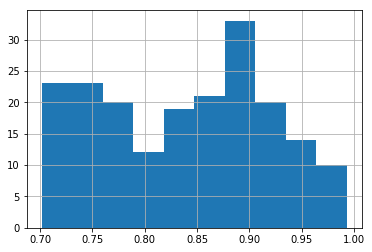

In [49]:
a['useful'].hist()

In [45]:
a['useful'].quantile(0.95)


0.6479658909399986

In [32]:
available_premises_for_conj(conjs[0]).to_frame()

/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


,premises
0,dt_k5_xboole_0
1,dt_k4_xboole_0
2,idempotence_k2_xboole_0
3,d3_xboole_0
4,commutativity_k5_xboole_0
5,d5_xboole_0
6,d6_xboole_0
7,antisymmetry_r2_hidden
8,commutativity_k2_xboole_0
9,dt_k2_xboole_0


In [57]:
available_premises_for_conj('t57_tmap_1').tail()

/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


4561          fc6_yellow19
4562    dt_o_2_13_yellow19
4563          t38_yellow19
4564          t34_waybel_0
4565            t5_funct_2
dtype: object

In [2]:
from sklearn.model_selection import train_test_split

In [4]:
import pandas as pd

In [11]:
df = pd.DataFrame([[1,2], [1,3],[3,5], [2,4]])
df.head()

,0,1
0,1,2
1,1,3
2,3,5
3,2,4


In [26]:
split = train_test_split(df[0].unique(), shuffle=True)

In [27]:
df[df[0].isin(split[0])]

,0,1
2,3,5
3,2,4


In [28]:
df

,0,1
0,1,2
1,1,3
2,3,5
3,2,4
